In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'ROB_599/mae_gan/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['proj.ipynb', 'PRETRAIN.md', 'LICENSE', 'submitit_pretrain.py', 'main_linprobe.py', 'CONTRIBUTING.md', 'FINETUNE.md', 'CODE_OF_CONDUCT.md', 'submitit_linprobe.py', 'README.md', 'submitit_finetune.py', 'main_pretrain.py', 'Progress-Objects-Sample', 'rob599', '.idea', '__pycache__', 'demo', 'util', 'train', 'engine_pretrain.py', 'output_dir_patchsize8', 'output_dir_gan50', 'output_dir', 'models_mae.py', 'val', 'main_finetune.py', 'finetune_output_dir', 'models_vit.py', 'engine_finetune.py']


In [5]:
%cd drive/MyDrive/ROB_599/mae_gan/

/content/drive/MyDrive/ROB_599/mae_gan


In [6]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
import requests
import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
else:
    sys.path.append('..')
import models_mae

Running in Colab.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 6.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1

In [6]:
import statistics
import random
import models_mae
%matplotlib inline


plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [7]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


In [8]:
import rob599

# Invoke the above function to get our data.
rob599.reset_seed(0)
x_train, y_train, x_test, y_test = rob599.data.progress_objects(x_dtype=torch.float64)

In [9]:
X_train = x_train.cuda()
y_train = y_train.cuda()
X_test = x_test.cuda()
y_test = y_test.cuda()

In [ ]:
mean = torch.mean(X_train, dim=[0, 2, 3])
std = torch.std(X_train, dim=[0, 2, 3])

print("Mean of each channel:", mean)
print("Standard deviation of each channel:", std)

Mean of each channel: tensor([0.4703, 0.4036, 0.3561], device='cuda:0', dtype=torch.float64)
Standard deviation of each channel: tensor([0.1796, 0.2076, 0.2056], device='cuda:0', dtype=torch.float64)


In [ ]:
from torchvision.utils import save_image
from torchvision import transforms
classes = [
        "master_chef_can",
				"cracker_box",
				"sugar_box",
				"tomato_soup_can",
				"mustard_bottle",
				"tuna_fish_can",
				"gelatin_box",
				"potted_meat_can",
				"mug",
				"large_marker"
		    ]
root_dir = './train'
for cls in classes:
    os.makedirs(os.path.join(root_dir, cls), exist_ok=True)

In [ ]:
'''
for idx, (image, label) in enumerate(zip(X_train, y_train)):
    print(idx)
    file_path = os.path.join(root_dir, classes[label.item()], f'image_{idx}.png')
    save_image(image, file_path)
print("All images have been saved.")
'''

In [ ]:
import argparse
import datetime
import json
import numpy as np
import os
import time
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import timm
import timm.optim.optim_factory as optim_factory

import util.misc as misc
from util.misc import NativeScalerWithGradNormCount as NativeScaler

import models_mae

from engine_pretrain import train_one_epoch

In [ ]:
def get_args_parser():
    parser = argparse.ArgumentParser('MAE pre-training', add_help=False)
    parser.add_argument('--batch_size', default=64, type=int,
                        help='Batch size per GPU (effective batch size is batch_size * accum_iter * # gpus')
    parser.add_argument('--epochs', default=30, type=int)
    parser.add_argument('--accum_iter', default=1, type=int,
                        help='Accumulate gradient iterations (for increasing the effective batch size under memory constraints)')

    # Model parameters
    parser.add_argument('--model', default='mae_vit_large_patch16', type=str, metavar='MODEL',
                        help='Name of model to train')

    parser.add_argument('--input_size', default=32, type=int,
                        help='images input size')

    parser.add_argument('--mask_ratio', default=0.75, type=float,
                        help='Masking ratio (percentage of removed patches).')

    parser.add_argument('--norm_pix_loss', action='store_true',
                        help='Use (per-patch) normalized pixels as targets for computing loss')
    parser.set_defaults(norm_pix_loss=False)

    # Optimizer parameters
    parser.add_argument('--weight_decay', type=float, default=0.05,
                        help='weight decay (default: 0.05)')

    parser.add_argument('--lr', type=float, default=None, metavar='LR',
                        help='learning rate (absolute lr)')
    parser.add_argument('--blr', type=float, default=1e-3, metavar='LR',
                        help='base learning rate: absolute_lr = base_lr * total_batch_size / 256')
    parser.add_argument('--min_lr', type=float, default=0., metavar='LR',
                        help='lower lr bound for cyclic schedulers that hit 0')

    parser.add_argument('--warmup_epochs', type=int, default=40, metavar='N',
                        help='epochs to warmup LR')

    # Dataset parameters
    parser.add_argument('--data_path', default='./train/', type=str,
                        help='dataset path')
    parser.add_argument('--output_dir', default='./output_dir',
                        help='path where to save, empty for no saving')
    parser.add_argument('--log_dir', default='./output_dir',
                        help='path where to tensorboard log')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=0, type=int)
    parser.add_argument('--resume', default='',
                        help='resume from checkpoint')

    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--num_workers', default=10, type=int)
    parser.add_argument('--pin_mem', action='store_true',
                        help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')
    parser.add_argument('--no_pin_mem', action='store_false', dest='pin_mem')
    parser.set_defaults(pin_mem=True)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--local_rank', default=-1, type=int)
    parser.add_argument('--dist_on_itp', action='store_true')
    parser.add_argument('--dist_url', default='env://',
                        help='url used to set up distributed training')

    return parser

In [ ]:
from torch.utils.data import DataLoader
def main(args):
    misc.init_distributed_mode(args)

    device = torch.device(args.device)

    # fix the seed for reproducibility
    seed = args.seed + misc.get_rank()
    torch.manual_seed(seed)
    np.random.seed(seed)

    cudnn.benchmark = True
    '''
    transform_basic = transforms.Compose([transforms.ToTensor()])

    dataset = datasets.ImageFolder(args.data_path, transform=transform_basic)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)

    # 计算均值和标准差
    def get_mean_and_std(loader):
        channels_sum, channels_squared_sum, num_batches = 0, 0, 0
        for data, _ in loader:
            channels_sum += torch.mean(data, dim=[0, 2, 3])
            channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
            num_batches += 1
        mean = channels_sum / num_batches
        std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
        return mean, std

    mean, std = get_mean_and_std(loader)
    print(f'Mean: {mean}, Std: {std}')
    '''
    # simple augmentation
    transform_train = transforms.Compose([
            transforms.RandomResizedCrop(args.input_size, scale=(0.2, 1.0), interpolation=3),  # 3 is bicubic
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4703, 0.4036, 0.3561], std=[0.1796, 0.2076, 0.2056])])
    dataset_train = datasets.ImageFolder(args.data_path, transform=transform_train)
    print(dataset_train)

    if True:  # args.distributed:
        num_tasks = misc.get_world_size()
        global_rank = misc.get_rank()
        sampler_train = torch.utils.data.DistributedSampler(
            dataset_train, num_replicas=num_tasks, rank=global_rank, shuffle=True
        )
        print("Sampler_train = %s" % str(sampler_train))
    else:
        sampler_train = torch.utils.data.RandomSampler(dataset_train)

    if global_rank == 0 and args.log_dir is not None:
        os.makedirs(args.log_dir, exist_ok=True)
        log_writer = SummaryWriter(log_dir=args.log_dir)
    else:
        log_writer = None

    data_loader_train = torch.utils.data.DataLoader(
        dataset_train, sampler=sampler_train,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        pin_memory=args.pin_mem,
        drop_last=True,
    )

    # define the model
    model = models_mae.__dict__[args.model](norm_pix_loss=args.norm_pix_loss)

    D = models_mae.discriminator()
    model.to(device)
    D.to(device)

    model_without_ddp = model
    print("Model = %s" % str(model_without_ddp))

    eff_batch_size = args.batch_size * args.accum_iter * misc.get_world_size()

    if args.lr is None:  # only base_lr is specified
        args.lr = args.blr * eff_batch_size / 256

    print("base lr: %.2e" % (args.lr * 256 / eff_batch_size))
    print("actual lr: %.2e" % args.lr)

    print("accumulate grad iterations: %d" % args.accum_iter)
    print("effective batch size: %d" % eff_batch_size)

    if args.distributed:
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu], find_unused_parameters=True)
        model_without_ddp = model.module

    # following timm: set wd as 0 for bias and norm layers
    #param_groups = optim_factory.add_weight_decay(model_without_ddp, args.weight_decay)
    #optimizer = torch.optim.AdamW(param_groups, lr=args.lr, betas=(0.9, 0.95))
    optimizer = torch.optim.AdamW(model_without_ddp.parameters(), lr=args.lr, betas=(0.9, 0.95),weight_decay=args.weight_decay)
    D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
    print(optimizer)
    print(D_optimizer)
    loss_scaler = NativeScaler()

    misc.load_model(args=args, model_without_ddp=model_without_ddp, optimizer=optimizer, loss_scaler=loss_scaler)

    print(f"Start training for {args.epochs} epochs")
    start_time = time.time()
    for epoch in range(args.start_epoch, args.epochs):
        if args.distributed:
            data_loader_train.sampler.set_epoch(epoch)
        train_stats = train_one_epoch(
            model, D, data_loader_train,
            optimizer, D_optimizer, device, epoch, loss_scaler,
            log_writer=log_writer,
            args=args
        )
        if args.output_dir and (epoch % 10 == 0 or epoch + 1 == args.epochs):
            misc.save_model(
                args=args, model=model, model_without_ddp=model_without_ddp, optimizer=optimizer,
                loss_scaler=loss_scaler, epoch=epoch)

        log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                        'epoch': epoch,}

        if args.output_dir and misc.is_main_process():
            if log_writer is not None:
                log_writer.flush()
            with open(os.path.join(args.output_dir, "log.txt"), mode="a", encoding="utf-8") as f:
                f.write(json.dumps(log_stats) + "\n")

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('Training time {}'.format(total_time_str))

In [ ]:
if __name__ == '__main__':
    args = get_args_parser()
    args = args.parse_args(args=[])
    if args.output_dir:
        Path(args.output_dir).mkdir(parents=True, exist_ok=True)
    main(args)


Not using distributed mode
[07:50:10.824089] Dataset ImageFolder
    Number of datapoints: 50000
    Root location: ./train/
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(32, 32), scale=(0.2, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.4703, 0.4036, 0.3561], std=[0.1796, 0.2076, 0.2056])
           )
[07:50:10.824428] Sampler_train = <torch.utils.data.distributed.DistributedSampler object at 0x7bc169dd29b0>


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[07:50:16.026602] Model = MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(4, 4), stride=(4, 4))
  )
  (blocks): ModuleList(
    (0-23): 24 x Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
  (decoder_embed): Linear(in_featur

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[07:52:05.905060] Epoch: [0]  [  0/781]  eta: 23:50:02  lr: 0.000000  loss: 577.7537 (577.7537)  time: 109.8630  data: 106.8947  max mem: 5918
[07:52:57.243631] Epoch: [0]  [ 20/781]  eta: 1:37:21  lr: 0.000000  loss: 539.6117 (542.3986)  time: 2.5669  data: 2.4275  max mem: 7760
[07:53:52.341725] Epoch: [0]  [ 40/781]  eta: 1:05:09  lr: 0.000000  loss: 413.1307 (485.0172)  time: 2.7548  data: 2.6082  max mem: 7760
[07:54:50.484413] Epoch: [0]  [ 60/781]  eta: 0:54:03  lr: 0.000000  loss: 298.3085 (423.1903)  time: 2.9071  data: 2.7625  max mem: 7760
[07:55:42.727944] Epoch: [0]  [ 80/781]  eta: 0:47:07  lr: 0.000001  loss: 214.4907 (372.8599)  time: 2.6121  data: 2.4658  max mem: 7760
[07:56:40.208112] Epoch: [0]  [100/781]  eta: 0:43:10  lr: 0.000001  loss: 195.4971 (337.7504)  time: 2.8739  data: 2.7291  max mem: 7760
[07:57:33.184558] Epoch: [0]  [120/781]  eta: 0:39:47  lr: 0.000001  loss: 186.0644 (312.8260)  time: 2.6488  data: 2.5032  max mem: 7760
[07:58:28.148835] Epoch: [0] 

In [6]:

imagenet_mean = np.array([0.4703, 0.4036, 0.3561])
imagenet_std = np.array([0.1796, 0.2076, 0.2056])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()
    print(f'MAE loss: {loss.item()}')
    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

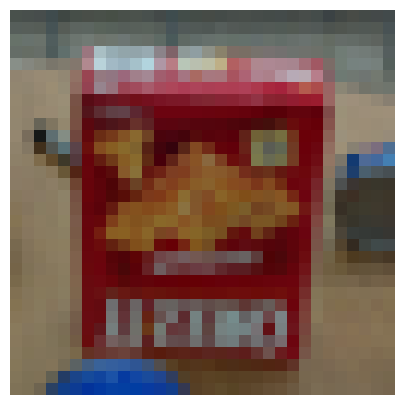

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
img = Image.open('./train/cracker_box/image_2278.png')
img = np.array(img) / 255.

assert img.shape == (32, 32, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

In [8]:
chkpt_dir = '/content/drive/MyDrive/ROB_599/mae_gan/output_dir/checkpoint-29.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


MAE with pixel reconstruction:
MAE loss: 0.23702406883239746


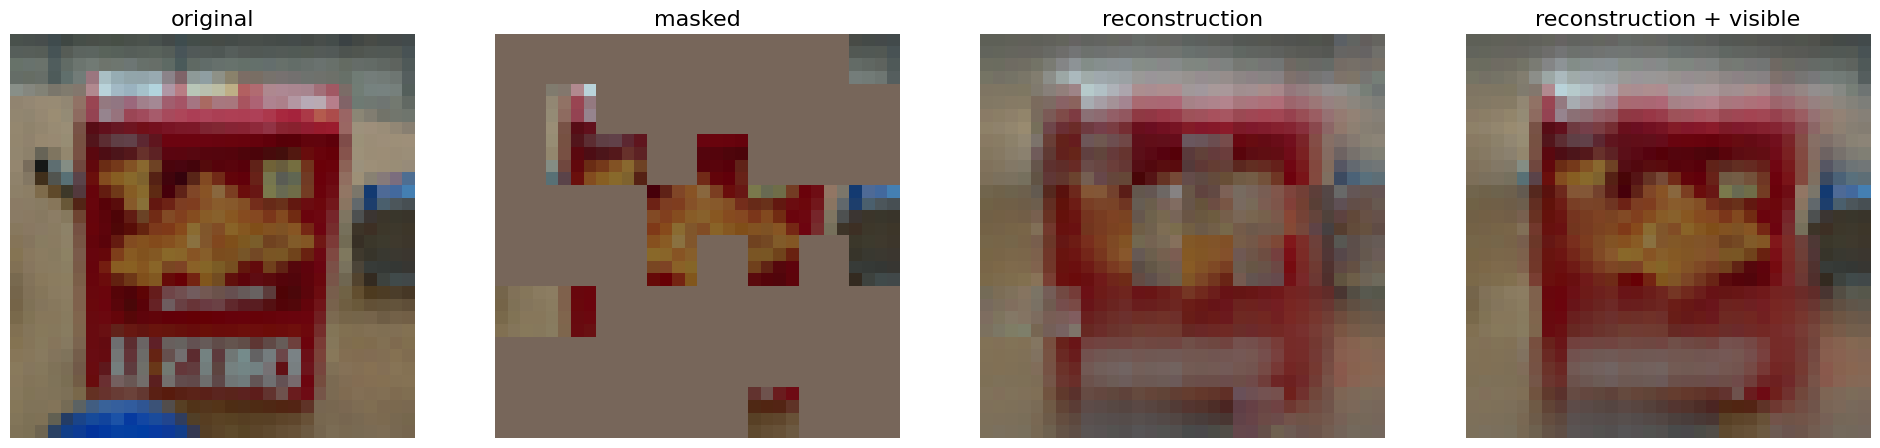

In [9]:
torch.manual_seed(2)
print('MAE with pixel reconstruction:')

run_one_image(img, model_mae)

In [10]:
chkpt_dir = '/content/drive/MyDrive/ROB_599/mae_gan/output_dir_gan50/checkpoint-29.pth'
model_mae_50 = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')


<All keys matched successfully>
Model loaded.


MAE with pixel reconstruction:
MAE loss: 0.2568461298942566


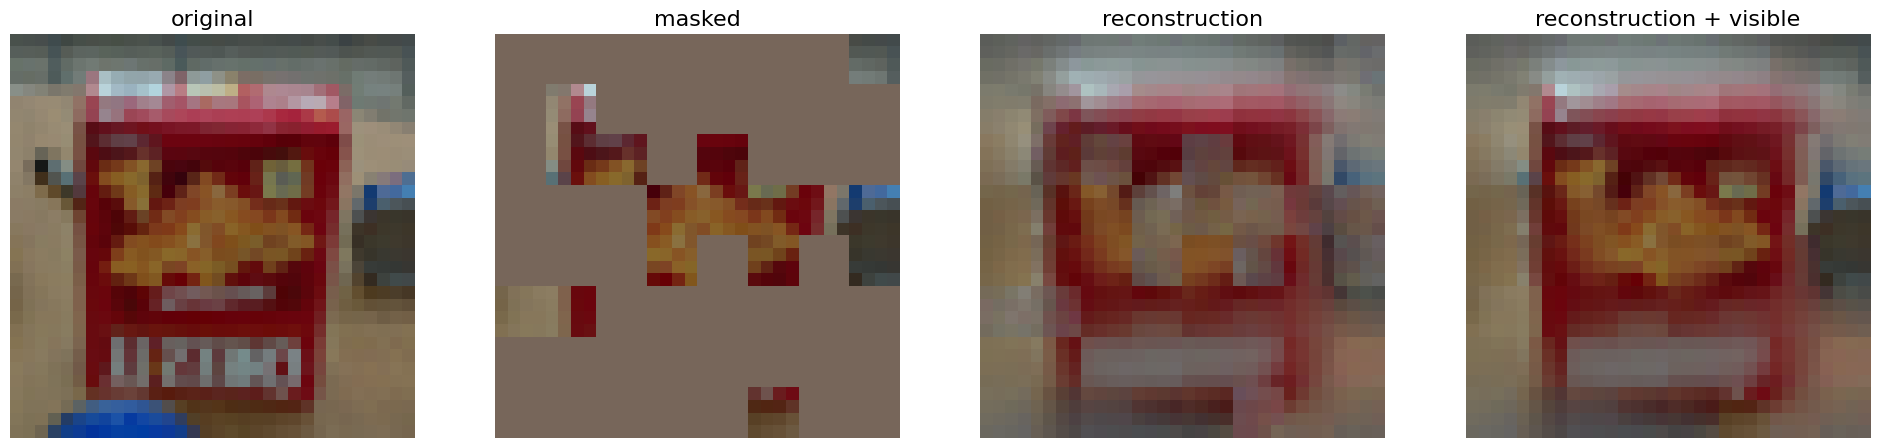

In [11]:
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae_50)

In [ ]:
classes = [
        "master_chef_can",
				"cracker_box",
				"sugar_box",
				"tomato_soup_can",
				"mustard_bottle",
				"tuna_fish_can",
				"gelatin_box",
				"potted_meat_can",
				"mug",
				"large_marker"
		    ]
root_dir = './val'
for cls in classes:
    os.makedirs(os.path.join(root_dir, cls), exist_ok=True)

In [ ]:
for idx, (image, label) in enumerate(zip(X_test, y_test)):
    print(idx)
    file_path = os.path.join(root_dir, classes[label.item()], f'image_{idx}.png')
    save_image(image, file_path)
print("All images have been saved.")

In [10]:
def get_args_parser():
    parser = argparse.ArgumentParser('MAE fine-tuning for image classification', add_help=False)
    parser.add_argument('--batch_size', default=64, type=int,
                        help='Batch size per GPU (effective batch size is batch_size * accum_iter * # gpus')
    parser.add_argument('--epochs', default=30, type=int)
    parser.add_argument('--accum_iter', default=1, type=int,
                        help='Accumulate gradient iterations (for increasing the effective batch size under memory constraints)')

    # Model parameters
    parser.add_argument('--model', default='vit_large_patch16', type=str, metavar='MODEL',
                        help='Name of model to train')

    parser.add_argument('--input_size', default=32, type=int,
                        help='images input size')

    parser.add_argument('--drop_path', type=float, default=0.1, metavar='PCT',
                        help='Drop path rate (default: 0.1)')

    # Optimizer parameters
    parser.add_argument('--clip_grad', type=float, default=None, metavar='NORM',
                        help='Clip gradient norm (default: None, no clipping)')
    parser.add_argument('--weight_decay', type=float, default=0.05,
                        help='weight decay (default: 0.05)')

    parser.add_argument('--lr', type=float, default=None, metavar='LR',
                        help='learning rate (absolute lr)')
    parser.add_argument('--blr', type=float, default=1e-3, metavar='LR',
                        help='base learning rate: absolute_lr = base_lr * total_batch_size / 256')
    parser.add_argument('--layer_decay', type=float, default=0.75,
                        help='layer-wise lr decay from ELECTRA/BEiT')

    parser.add_argument('--min_lr', type=float, default=1e-6, metavar='LR',
                        help='lower lr bound for cyclic schedulers that hit 0')

    parser.add_argument('--warmup_epochs', type=int, default=5, metavar='N',
                        help='epochs to warmup LR')

    # Augmentation parameters
    parser.add_argument('--color_jitter', type=float, default=None, metavar='PCT',
                        help='Color jitter factor (enabled only when not using Auto/RandAug)')
    parser.add_argument('--aa', type=str, default='rand-m9-mstd0.5-inc1', metavar='NAME',
                        help='Use AutoAugment policy. "v0" or "original". " + "(default: rand-m9-mstd0.5-inc1)'),
    parser.add_argument('--smoothing', type=float, default=0.1,
                        help='Label smoothing (default: 0.1)')

    # * Random Erase params
    parser.add_argument('--reprob', type=float, default=0.25, metavar='PCT',
                        help='Random erase prob (default: 0.25)')
    parser.add_argument('--remode', type=str, default='pixel',
                        help='Random erase mode (default: "pixel")')
    parser.add_argument('--recount', type=int, default=1,
                        help='Random erase count (default: 1)')
    parser.add_argument('--resplit', action='store_true', default=False,
                        help='Do not random erase first (clean) augmentation split')

    # * Mixup params
    parser.add_argument('--mixup', type=float, default=0,
                        help='mixup alpha, mixup enabled if > 0.')
    parser.add_argument('--cutmix', type=float, default=0,
                        help='cutmix alpha, cutmix enabled if > 0.')
    parser.add_argument('--cutmix_minmax', type=float, nargs='+', default=None,
                        help='cutmix min/max ratio, overrides alpha and enables cutmix if set (default: None)')
    parser.add_argument('--mixup_prob', type=float, default=1.0,
                        help='Probability of performing mixup or cutmix when either/both is enabled')
    parser.add_argument('--mixup_switch_prob', type=float, default=0.5,
                        help='Probability of switching to cutmix when both mixup and cutmix enabled')
    parser.add_argument('--mixup_mode', type=str, default='batch',
                        help='How to apply mixup/cutmix params. Per "batch", "pair", or "elem"')

    # * Finetuning params
    parser.add_argument('--finetune', default= '/content/drive/MyDrive/ROB_599/mae_gan/output_dir/checkpoint-29.pth',
                        help='finetune from checkpoint')
    parser.add_argument('--global_pool', action='store_true')
    parser.set_defaults(global_pool=False)
    parser.add_argument('--cls_token', action='store_false', dest='global_pool',
                        help='Use class token instead of global pool for classification')

    # Dataset parameters
    parser.add_argument('--data_path', default='./', type=str,
                        help='dataset path')
    parser.add_argument('--nb_classes', default=10, type=int,
                        help='number of the classification types')

    parser.add_argument('--output_dir', default='./finetune_output_dir',
                        help='path where to save, empty for no saving')
    parser.add_argument('--log_dir', default='./finetune_output_dir',
                        help='path where to tensorboard log')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=0, type=int)
    parser.add_argument('--resume', default=False,
                        help='resume from checkpoint')

    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true',default=False,
                        help='Perform evaluation only')
    parser.add_argument('--dist_eval', action='store_true', default=False,
                        help='Enabling distributed evaluation (recommended during training for faster monitor')
    parser.add_argument('--num_workers', default=10, type=int)
    parser.add_argument('--pin_mem', action='store_true',
                        help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')
    parser.add_argument('--no_pin_mem', action='store_false', dest='pin_mem')
    parser.set_defaults(pin_mem=True)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--local_rank', default=-1, type=int)
    parser.add_argument('--dist_on_itp', action='store_true')
    parser.add_argument('--dist_url', default='env://',
                        help='url used to set up distributed training')

    return parser

In [11]:
import argparse
import datetime
import json
import numpy as np
import os
import time
from pathlib import Path

import torch
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter

from timm.models.layers import trunc_normal_
from timm.data.mixup import Mixup
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy

import util.lr_decay as lrd
import util.misc as misc
from util.datasets import build_dataset
from util.pos_embed import interpolate_pos_embed
from util.misc import NativeScalerWithGradNormCount as NativeScaler

import models_vit

from engine_finetune import train_one_epoch, evaluate
def evaluation(args):
    misc.init_distributed_mode(args)


    device = torch.device(args.device)

    # fix the seed for reproducibility
    seed = args.seed + misc.get_rank()
    torch.manual_seed(seed)
    np.random.seed(seed)

    cudnn.benchmark = True

    dataset_train = build_dataset(is_train=True, args=args)
    dataset_val = build_dataset(is_train=False, args=args)

    if True:  # args.distributed:
        num_tasks = misc.get_world_size()
        global_rank = misc.get_rank()
        sampler_train = torch.utils.data.DistributedSampler(
            dataset_train, num_replicas=num_tasks, rank=global_rank, shuffle=True
        )
        print("Sampler_train = %s" % str(sampler_train))
        if args.dist_eval:
            if len(dataset_val) % num_tasks != 0:
                print('Warning: Enabling distributed evaluation with an eval dataset not divisible by process number. '
                      'This will slightly alter validation results as extra duplicate entries are added to achieve '
                      'equal num of samples per-process.')
            sampler_val = torch.utils.data.DistributedSampler(
                dataset_val, num_replicas=num_tasks, rank=global_rank, shuffle=True)  # shuffle=True to reduce monitor bias
        else:
            sampler_val = torch.utils.data.SequentialSampler(dataset_val)
    else:
        sampler_train = torch.utils.data.RandomSampler(dataset_train)
        sampler_val = torch.utils.data.SequentialSampler(dataset_val)

    if global_rank == 0 and args.log_dir is not None and not args.eval:
        os.makedirs(args.log_dir, exist_ok=True)
        log_writer = SummaryWriter(log_dir=args.log_dir)
    else:
        log_writer = None

    data_loader_train = torch.utils.data.DataLoader(
        dataset_train, sampler=sampler_train,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        pin_memory=args.pin_mem,
        drop_last=True,
    )

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, sampler=sampler_val,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        pin_memory=args.pin_mem,
        drop_last=False
    )

    mixup_fn = None
    mixup_active = args.mixup > 0 or args.cutmix > 0. or args.cutmix_minmax is not None
    if mixup_active:
        print("Mixup is activated!")
        mixup_fn = Mixup(
            mixup_alpha=args.mixup, cutmix_alpha=args.cutmix, cutmix_minmax=args.cutmix_minmax,
            prob=args.mixup_prob, switch_prob=args.mixup_switch_prob, mode=args.mixup_mode,
            label_smoothing=args.smoothing, num_classes=args.nb_classes)

    model = models_vit.__dict__[args.model](
        num_classes=args.nb_classes,
        drop_path_rate=args.drop_path,
        global_pool=args.global_pool,
    )

    if args.finetune and not args.eval:
        checkpoint = torch.load(args.finetune, map_location='cuda')

        print("Load pre-trained checkpoint from: %s" % args.finetune)
        checkpoint_model = checkpoint['model']
        state_dict = model.state_dict()
        for k in ['head.weight', 'head.bias']:
            if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
                print(f"Removing key {k} from pretrained checkpoint")
                del checkpoint_model[k]

        # interpolate position embedding
        interpolate_pos_embed(model, checkpoint_model)

        # load pre-trained model
        msg = model.load_state_dict(checkpoint_model, strict=False)
        print(msg)

        if args.global_pool:
            assert set(msg.missing_keys) == {'head.weight', 'head.bias', 'fc_norm.weight', 'fc_norm.bias'}
        else:
            assert set(msg.missing_keys) == {'head.weight', 'head.bias'}
        # manually initialize fc layer
        trunc_normal_(model.head.weight, std=2e-5)

    model.to(device)

    model_without_ddp = model
    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print("Model = %s" % str(model_without_ddp))
    print('number of params (M): %.2f' % (n_parameters / 1.e6))

    eff_batch_size = args.batch_size * args.accum_iter * misc.get_world_size()

    if args.lr is None:  # only base_lr is specified
        args.lr = args.blr * eff_batch_size / 256

    print("base lr: %.2e" % (args.lr * 256 / eff_batch_size))
    print("actual lr: %.2e" % args.lr)

    print("accumulate grad iterations: %d" % args.accum_iter)
    print("effective batch size: %d" % eff_batch_size)

    if args.distributed:
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu])
        model_without_ddp = model.module

    # build optimizer with layer-wise lr decay (lrd)
    param_groups = lrd.param_groups_lrd(model_without_ddp, args.weight_decay,
        no_weight_decay_list=model_without_ddp.no_weight_decay(),
        layer_decay=args.layer_decay
    )
    optimizer = torch.optim.AdamW(param_groups, lr=args.lr)
    loss_scaler = NativeScaler()

    if mixup_fn is not None:
        # smoothing is handled with mixup label transform
        criterion = SoftTargetCrossEntropy()
    elif args.smoothing > 0.:
        criterion = LabelSmoothingCrossEntropy(smoothing=args.smoothing)
    else:
        criterion = torch.nn.CrossEntropyLoss()

    print("criterion = %s" % str(criterion))

    misc.load_model(args=args, model_without_ddp=model_without_ddp, optimizer=optimizer, loss_scaler=loss_scaler)

    if args.eval:
        test_stats = evaluate(data_loader_val, model, device)
        print(f"Accuracy of the network on the {len(dataset_val)} test images: {test_stats['acc1']:.1f}%")
        exit(0)

    print(f"Start training for {args.epochs} epochs")
    start_time = time.time()
    max_accuracy = 0.0
    for epoch in range(args.start_epoch, args.epochs):
        if args.distributed:
            data_loader_train.sampler.set_epoch(epoch)
        train_stats = train_one_epoch(
            model, criterion, data_loader_train,
            optimizer, device, epoch, loss_scaler,
            args.clip_grad, mixup_fn,
            log_writer=log_writer,
            args=args
        )
        if args.output_dir:
            misc.save_model(
                args=args, model=model, model_without_ddp=model_without_ddp, optimizer=optimizer,
                loss_scaler=loss_scaler, epoch=epoch)

        test_stats = evaluate(data_loader_val, model, device)
        print(f"Accuracy of the network on the {len(dataset_val)} test images: {test_stats['acc1']:.1f}%")
        max_accuracy = max(max_accuracy, test_stats["acc1"])
        print(f'Max accuracy: {max_accuracy:.2f}%')

        if log_writer is not None:
            log_writer.add_scalar('perf/test_acc1', test_stats['acc1'], epoch)
            log_writer.add_scalar('perf/test_acc5', test_stats['acc5'], epoch)
            log_writer.add_scalar('perf/test_loss', test_stats['loss'], epoch)

        log_stats = {**{f'train_{k}': v for k, v in train_stats.items()},
                        **{f'test_{k}': v for k, v in test_stats.items()},
                        'epoch': epoch,
                        'n_parameters': n_parameters}

        if args.output_dir and misc.is_main_process():
            if log_writer is not None:
                log_writer.flush()
            with open(os.path.join(args.output_dir, "log.txt"), mode="a", encoding="utf-8") as f:
                f.write(json.dumps(log_stats) + "\n")

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print('Training time {}'.format(total_time_str))


In [12]:
args = get_args_parser()
args = args.parse_args(args=[])
if args.output_dir:
  Path(args.output_dir).mkdir(parents=True, exist_ok=True)
evaluation(args)

[17:25:29.176219] Not using distributed mode
[17:25:31.254479] [17:25:31.254451] [17:25:31.254589] Dataset ImageFolder
    Number of datapoints: 50000
    Root location: ./train
    StandardTransform
Transform: Compose(
               RandomResizedCropAndInterpolation(size=(32, 32), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BICUBIC)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=tensor([0.4703, 0.4036, 0.3561]), std=tensor([0.1796, 0.2076, 0.2056]))
           )
[17:25:31.487541] [17:25:31.487516] [17:25:31.487641] Dataset ImageFolder
    Number of datapoints: 10000
    Root location: ./val
    StandardTransform
Transform: Compose(
               Resize(size=36, interpolation=bicubic, max_size=None, antialias=True)
               CenterCrop(size=(32, 32))
               ToTensor()
               Normalize(mean=[0.4703, 0.4036, 0.3561], std=[0.1796, 0.2076, 0.2056])
           )
[17:25:31.487820] [17:25:31.487814

KeyboardInterrupt: 